In [1]:
# Cell 1: Setup - Install Libraries (Revised for stability AND newer datasets version)
!pip install --upgrade pip

# Upgrade or reinstall NumPy and Pandas first
!pip install --upgrade numpy pandas

# Upgrade datasets library to ensure trust_remote_code is supported
!pip install --upgrade datasets

# Then install the other packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install scikit-learn gensim matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pandas]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from datasets import load_dataset
import re
import string
from collections import Counter
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # For progress bars in Colab
import gensim # For CBOW

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Hyperparameters
MAX_LEN = 30  # Max sequence length for Seq2Seq
BATCH_SIZE = 64
EMBEDDING_DIM_CBOW = 100 # Dimension for Gensim CBOW embeddings
EMBEDDING_DIM_SEQ2SEQ = 256 # Dimension for Seq2Seq model embeddings (can be same as CBOW or different)
HIDDEN_DIM = 512
NUM_LSTM_LAYERS = 1 # For "simplest possible LSTM"
LEARNING_RATE = 0.001
NUM_EPOCHS = 10 # Adjust as needed
TEACHER_FORCING_RATIO = 0.5
MIN_WORD_FREQ_VOCAB = 3 # For Seq2Seq vocabulary
MIN_WORD_FREQ_CBOW = 1  # For CBOW training, can be lower to get more word vectors
DATA_SUBSET_SIZE = None # e.g., 20000 for faster dev, None for full dataset

# Special tokens for Seq2Seq
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>" # Start Of Sentence
EOS_TOKEN = "<eos>" # End Of Sentence
UNK_TOKEN = "<unk>" # Unknown word

PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX = 0, 1, 2, 3 # Will be set after vocab creation

Using device: cuda


--- 2.1 Data Preparation ---
2.1.1 & 2.1.2: Loading, preprocessing, and extracting sentence pairs...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

multi_woz_v22.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8437 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset 'pfb30/multi_woz_v22' loaded. Dialogues in 'train': 8437


Extracting Raw Pairs:   0%|          | 0/8437 [00:00<?, ?it/s]

Preprocessing Pairs:   0%|          | 0/56776 [00:00<?, ?it/s]

Preprocessing complete. Kept 56776 pairs.
Example processed pair: User: ['i', 'need', 'a', 'place', 'to', 'dine', 'in', 'the', 'center', 'thats', 'expensive'], System: ['i', 'have', 'several', 'options', 'for', 'you', 'do', 'you', 'prefer', 'african', 'asian', 'or', 'british', 'food']

2.1.3: Creating vocabulary for Seq2Seq model...
Seq2Seq Vocabulary size: 3566 (min_freq=3)

2.1.4: Generating histograms...


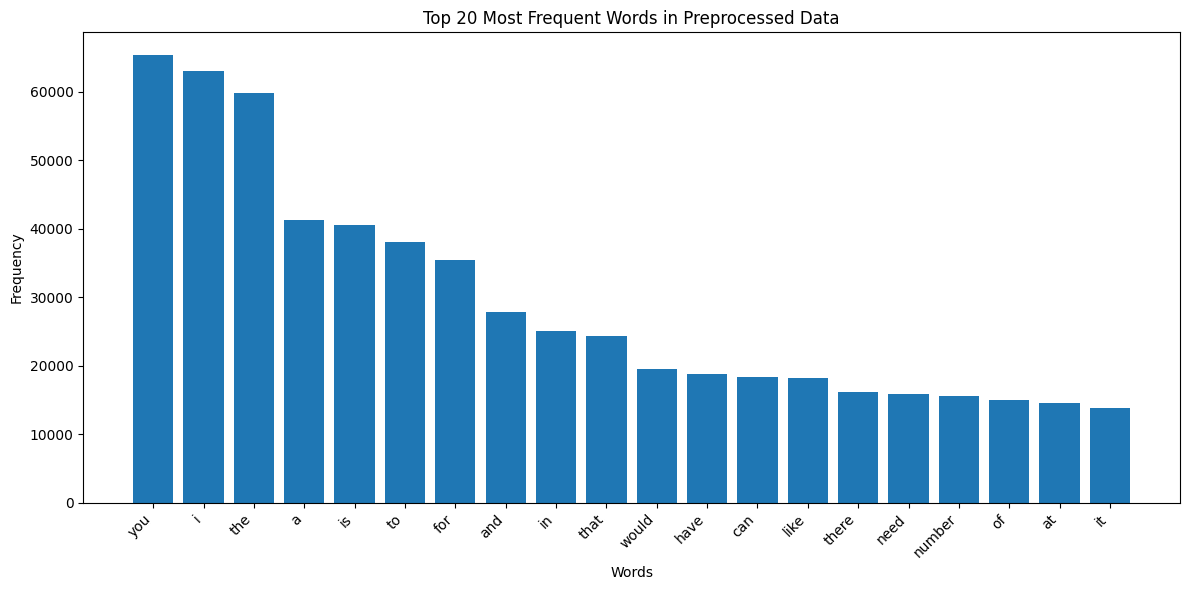

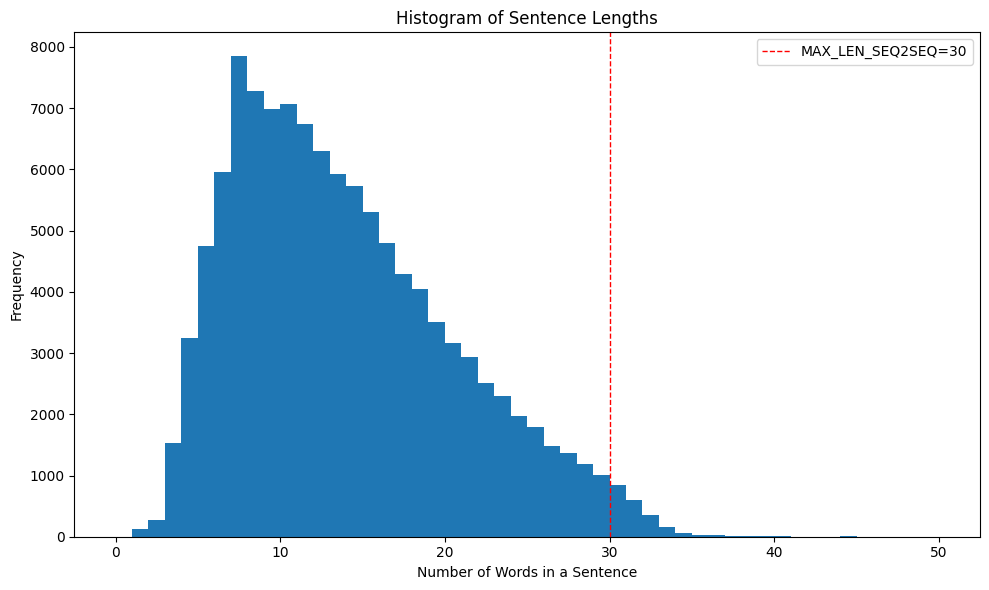

Average sentence length: 13.48, Max sentence length: 90


In [2]:
# --- 2.1 Data Preparation ---
print("--- 2.1 Data Preparation ---")

# --- 2.1.1 Select a dataset & 2.1.2 Preprocess data ---
print("2.1.1 & 2.1.2: Loading, preprocessing, and extracting sentence pairs...")
try:
    multi_woz_hub_dataset = load_dataset("pfb30/multi_woz_v22", trust_remote_code=True)
    dataset_split = multi_woz_hub_dataset['train']
    print(f"Dataset 'pfb30/multi_woz_v22' loaded. Dialogues in 'train': {len(dataset_split)}")
except Exception as e:
    print(f"Error loading dataset: {e}. Exiting.")
    exit()

dialogue_pairs_raw = []
for dialogue_obj in tqdm(dataset_split, desc="Extracting Raw Pairs"):
    turns_data = dialogue_obj.get('turns')
    if turns_data and 'utterance' in turns_data and 'speaker' in turns_data:
        utterances = turns_data['utterance']
        speakers = turns_data['speaker']
        for i in range(len(utterances) - 1):
            if speakers[i] == 0 and speakers[i+1] == 1: # User (0) -> System (1)
                user_utt = utterances[i]
                system_utt = utterances[i+1]
                if user_utt and system_utt:
                    dialogue_pairs_raw.append((user_utt, system_utt))

if DATA_SUBSET_SIZE and DATA_SUBSET_SIZE < len(dialogue_pairs_raw):
    dialogue_pairs_raw = random.sample(dialogue_pairs_raw, DATA_SUBSET_SIZE)
    print(f"Using a subset of {len(dialogue_pairs_raw)} raw pairs.")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[" + string.punctuation + "]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    return tokens

processed_pairs = [] # List of (user_tokens, system_tokens)
all_processed_sentences_for_cbow = [] # List of tokenized sentences for CBOW
sentence_lengths = []

for user_utt, system_utt in tqdm(dialogue_pairs_raw, desc="Preprocessing Pairs"):
    user_tokens = preprocess_text(user_utt)
    system_tokens = preprocess_text(system_utt)
    if user_tokens and system_tokens:
        processed_pairs.append((user_tokens, system_tokens))
        all_processed_sentences_for_cbow.append(user_tokens)
        all_processed_sentences_for_cbow.append(system_tokens)
        sentence_lengths.append(len(user_tokens))
        sentence_lengths.append(len(system_tokens))

print(f"Preprocessing complete. Kept {len(processed_pairs)} pairs.")
if processed_pairs:
    print(f"Example processed pair: User: {processed_pairs[0][0]}, System: {processed_pairs[0][1]}")
else:
    print("No pairs left after preprocessing. Exiting.")
    exit()

# --- 2.1.3 Create a dictionary (Vocabulary for Seq2Seq) ---
print("\n2.1.3: Creating vocabulary for Seq2Seq model...")
word_counts_seq2seq = Counter()
for user_tokens, system_tokens in processed_pairs:
    word_counts_seq2seq.update(user_tokens)
    word_counts_seq2seq.update(system_tokens)

# Vocab for Seq2Seq model
vocab_seq2seq = {word: count for word, count in word_counts_seq2seq.items() if count >= MIN_WORD_FREQ_VOCAB}
word_to_idx = {PAD_TOKEN: PAD_IDX, SOS_TOKEN: SOS_IDX, EOS_TOKEN: EOS_IDX, UNK_TOKEN: UNK_IDX}
# Adjust PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX if they are not 0,1,2,3 respectively
# The current assignment PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX = 0, 1, 2, 3 is fine.
current_idx = 4 # Start after special tokens
for word in vocab_seq2seq.keys():
    if word not in word_to_idx: # Ensure not to overwrite special tokens if they appear in vocab_seq2seq
        word_to_idx[word] = current_idx
        current_idx += 1


idx_to_word = {i: word for word, i in word_to_idx.items()}
VOCAB_SIZE_SEQ2SEQ = len(word_to_idx)
print(f"Seq2Seq Vocabulary size: {VOCAB_SIZE_SEQ2SEQ} (min_freq={MIN_WORD_FREQ_VOCAB})")

# --- 2.1.4 Create histograms ---
print("\n2.1.4: Generating histograms...")

# Histogram of frequent words (from word_counts_seq2seq for overall frequency)
most_common_words = word_counts_seq2seq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Words in Preprocessed Data")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Histogram of the number of words in a sentence
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=50, range=(0, MAX_LEN + 20)) # Show a bit beyond MAX_LEN
plt.xlabel("Number of Words in a Sentence")
plt.ylabel("Frequency")
plt.title("Histogram of Sentence Lengths")
plt.axvline(MAX_LEN, color='r', linestyle='dashed', linewidth=1, label=f'MAX_LEN_SEQ2SEQ={MAX_LEN}')
plt.legend()
plt.tight_layout()
plt.show()
print(f"Average sentence length: {np.mean(sentence_lengths):.2f}, Max sentence length: {np.max(sentence_lengths)}")


--- 2.2 Word Embedding (CBOW with Gensim) ---
2.2.1: Training CBOW model using Gensim Word2Vec...
CBOW model training complete.
CBOW Vocabulary size: 14577

2.2.2: Assessing CBOW model...
Words similar to 'hello': [('hi', 0.9230290055274963), ('hey', 0.7393957376480103), ('greetings', 0.6422188878059387), ('also', 0.5756356120109558), ('seeing', 0.5082314610481262)]
Words similar to 'restaurant': [('tang', 0.5386279225349426), ('restaraunts', 0.5314478278160095), ('restaurants', 0.5227027535438538), ('gastropub', 0.5207827091217041), ('place', 0.5073914527893066)]
Words similar to 'book': [('reserve', 0.8476651906967163), ('make', 0.563692569732666), ('igonqkg9', 0.44863981008529663), ('yay', 0.43380704522132874), ('2312', 0.423700749874115)]
Words similar to 'time': [('times', 0.6444715261459351), ('destination', 0.5748143196105957), ('location', 0.5397817492485046), ('site', 0.5323518514633179), ('day', 0.5007379651069641)]
Words similar to 'london': [('birmingham', 0.89966982603073

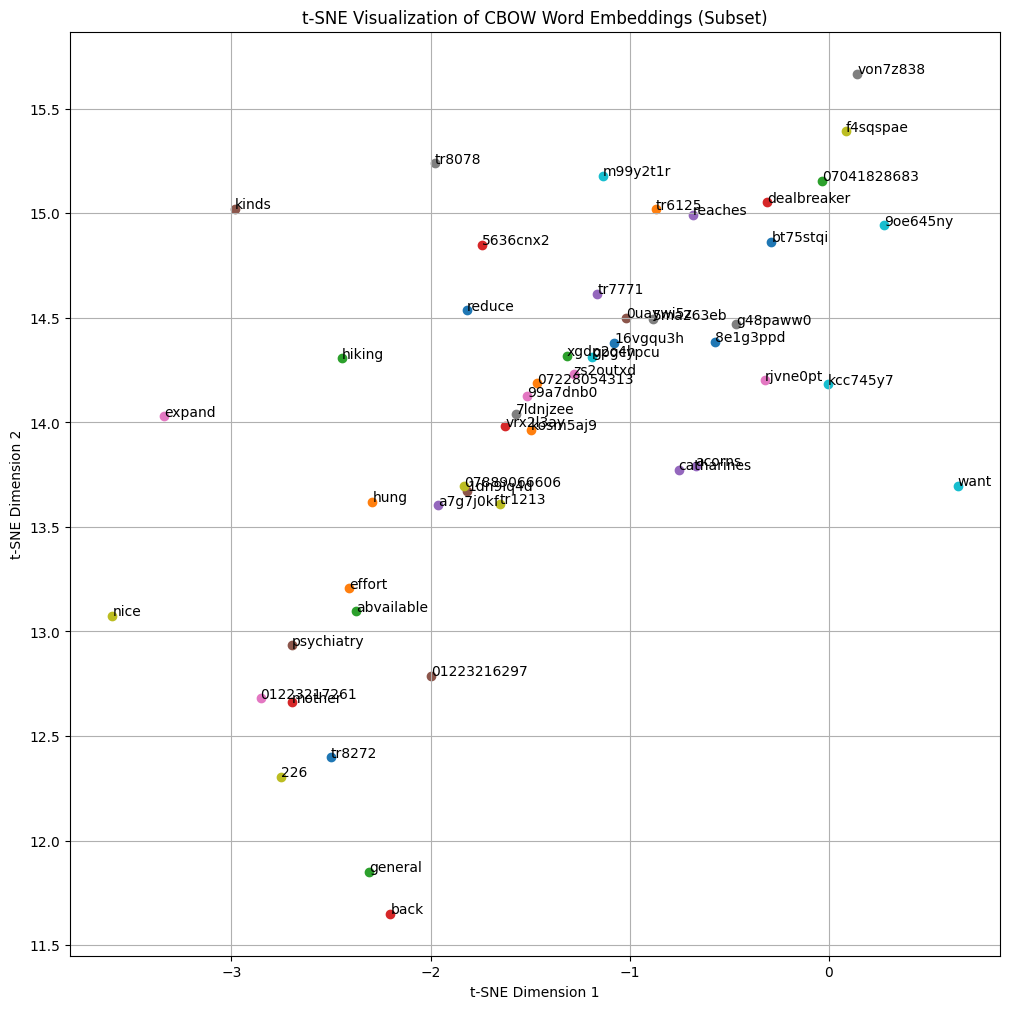

Using EMBEDDING_DIM_SEQ2SEQ: 100 (matched to CBOW)
Initialized Seq2Seq embedding matrix. 3562/3566 words found in CBOW model and loaded (PAD set to zeros).


<ipython-input-3-b036c5e9de8b>:66: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  pretrained_embeddings[idx] = torch.FloatTensor(cbow_model.wv[word])


In [3]:
# --- 2.2 Word Embedding ---
print("\n--- 2.2 Word Embedding (CBOW with Gensim) ---")

# --- 2.2.1 Map words into vectors using CBOW model ---
print("2.2.1: Training CBOW model using Gensim Word2Vec...")
# Ensure all_processed_sentences_for_cbow contains lists of strings (tokens)
# Gensim Word2Vec: cbow=1 for CBOW model
cbow_model = gensim.models.Word2Vec(
    sentences=all_processed_sentences_for_cbow,
    vector_size=EMBEDDING_DIM_CBOW,
    window=5,         # Context window size
    min_count=MIN_WORD_FREQ_CBOW, # Ignores words with frequency lower than this
    sg=0,             # 0 for CBOW, 1 for Skip-gram
    workers=4         # Number of worker threads
)
print("CBOW model training complete.")
print(f"CBOW Vocabulary size: {len(cbow_model.wv.key_to_index)}")

# --- 2.2.2 Assess your model ---
print("\n2.2.2: Assessing CBOW model...")

# Show nearest words for some example words
example_words = ["hello", "restaurant", "book", "time", "london"]
for word in example_words:
    if word in cbow_model.wv:
        similar_words = cbow_model.wv.most_similar(word, topn=5)
        print(f"Words similar to '{word}': {similar_words}")
    else:
        print(f"Word '{word}' not in CBOW vocabulary.")

# Visualize word embeddings (using t-SNE)
print("\nVisualizing word embeddings using t-SNE (subset of vocab)...")
# Take a larger sample if possible, but ensure they are in CBOW vocab
words_in_cbow_vocab = [word for word in word_counts_seq2seq.keys() if word in cbow_model.wv]
words_to_visualize = random.sample(words_in_cbow_vocab, min(50, len(words_in_cbow_vocab)))

if words_to_visualize:
    word_vectors = np.array([cbow_model.wv[word] for word in words_to_visualize])

    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(words_to_visualize)-1)) # Perplexity must be less than n_samples
    word_vectors_2d = tsne.fit_transform(word_vectors)

    plt.figure(figsize=(12, 12))
    for i, word in enumerate(words_to_visualize):
        plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
        plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]))
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title("t-SNE Visualization of CBOW Word Embeddings (Subset)")
    plt.grid(True)
    plt.show()
else:
    print("Not enough words in CBOW model from the most common list to visualize.")


# Prepare pre-trained embedding matrix for Seq2Seq model
EMBEDDING_DIM_SEQ2SEQ = EMBEDDING_DIM_CBOW # Match dimensions
print(f"Using EMBEDDING_DIM_SEQ2SEQ: {EMBEDDING_DIM_SEQ2SEQ} (matched to CBOW)")

pretrained_embeddings = torch.randn(VOCAB_SIZE_SEQ2SEQ, EMBEDDING_DIM_SEQ2SEQ)
words_found_cbow = 0
for word, idx in word_to_idx.items():
    if idx == PAD_IDX: # Ensure PAD_IDX is handled correctly
        pretrained_embeddings[idx] = torch.zeros(EMBEDDING_DIM_SEQ2SEQ)
    elif word in cbow_model.wv:
        pretrained_embeddings[idx] = torch.FloatTensor(cbow_model.wv[word])
        words_found_cbow += 1
    # Other special tokens (SOS, EOS, UNK) will keep their random init or you can define specific vectors

print(f"Initialized Seq2Seq embedding matrix. {words_found_cbow}/{VOCAB_SIZE_SEQ2SEQ} words found in CBOW model and loaded (PAD set to zeros).")

In [4]:
# --- 2.3 Chatbot with Sequence-to-Sequence Model ---
print("\n--- 2.3 Chatbot with Sequence-to-Sequence Model ---")

# --- 2.3.2 Split the data into train-test set ---
print("2.3.2: Splitting data into train and test sets...")
train_pairs, test_pairs = train_test_split(processed_pairs, test_size=0.3, random_state=42)
print(f"Training pairs: {len(train_pairs)}, Testing pairs: {len(test_pairs)}")

class ChatbotDataset(Dataset):
    def __init__(self, pairs, word_to_idx_map, max_len_val):
        self.pairs = pairs
        self.word_to_idx = word_to_idx_map
        self.max_len = max_len_val
        # Directly use global constants for special token indices
        self.unk_idx = UNK_IDX
        self.sos_idx = SOS_IDX
        self.eos_idx = EOS_IDX

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        user_tokens, system_tokens = self.pairs[idx]
        user_num = [self.sos_idx] + [self.word_to_idx.get(t, self.unk_idx) for t in user_tokens][:self.max_len-2] + [self.eos_idx]
        system_num = [self.sos_idx] + [self.word_to_idx.get(t, self.unk_idx) for t in system_tokens][:self.max_len-2] + [self.eos_idx]
        return torch.LongTensor(user_num), torch.LongTensor(system_num)

def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=PAD_IDX)
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=PAD_IDX)
    return src_padded, trg_padded

train_dataset = ChatbotDataset(train_pairs, word_to_idx, MAX_LEN)
test_dataset = ChatbotDataset(test_pairs, word_to_idx, MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2)

print("DataLoaders created.")


--- 2.3 Chatbot with Sequence-to-Sequence Model ---
2.3.2: Splitting data into train and test sets...
Training pairs: 39743, Testing pairs: 17033
DataLoaders created.


In [5]:
# --- Model Definitions ---

# --- 2.3.1 & 2.3.5: Simplest LSTM Network (No Attention) ---
class EncoderLSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, pretrained_vecs=None):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=PAD_IDX)
        if pretrained_vecs is not None:
            print("Loading pretrained embeddings into Encoder.")
            self.embedding.weight.data.copy_(pretrained_vecs)
            # self.embedding.weight.requires_grad = False # Optionally freeze
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout if n_layers > 1 else 0, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [batch_size, src_len]
        embedded = self.dropout(self.embedding(src))  # [batch_size, src_len, emb_dim]
        outputs, (hidden, cell) = self.rnn(embedded) # outputs are all hidden states, hidden/cell is final
        # outputs = [batch_size, src_len, hid_dim]
        # hidden, cell = [n_layers, batch_size, hid_dim]
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, pretrained_vecs=None):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=PAD_IDX)
        if pretrained_vecs is not None:
            print("Loading pretrained embeddings into Decoder.")
            self.embedding.weight.data.copy_(pretrained_vecs)
            # self.embedding.weight.requires_grad = False # Optionally freeze
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout if n_layers > 1 else 0, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, cell, encoder_outputs=None): # encoder_outputs not used here
        # input_token = [batch_size]
        input_token = input_token.unsqueeze(1) # [batch_size, 1]
        embedded = self.dropout(self.embedding(input_token)) # [batch_size, 1, emb_dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [batch_size, 1, hid_dim]
        prediction = self.fc_out(output.squeeze(1)) # [batch_size, output_dim]
        return prediction, hidden, cell, None # Return None for attention_weights

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [batch_size, src_len], trg = [batch_size, trg_len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs_tensor = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(src)

        decoder_input = trg[:, 0] # <sos> token

        for t in range(1, trg_len):
            decoder_output, hidden, cell, _ = self.decoder(decoder_input, hidden, cell, encoder_outputs) # Pass encoder_outputs
            outputs_tensor[:, t] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = decoder_output.argmax(1)
            decoder_input = trg[:, t] if teacher_force else top1
        return outputs_tensor

# --- 2.3.6: Upgrade the Chatbot to include attention ---
class Attention(nn.Module): # General/Additive Attention (Bahdanau style variant)
    def __init__(self, hid_dim_encoder, hid_dim_decoder):
        super().__init__()
        self.attn_W = nn.Linear(hid_dim_encoder + hid_dim_decoder, hid_dim_decoder)
        self.attn_v = nn.Linear(hid_dim_decoder, 1, bias=False)

    def forward(self, decoder_hidden_prev, encoder_outputs):
        # decoder_hidden_prev = [batch_size, hid_dim_decoder] (top layer hidden state from previous step)
        # encoder_outputs = [batch_size, src_len, hid_dim_encoder]
        src_len = encoder_outputs.shape[1]

        repeated_decoder_hidden = decoder_hidden_prev.unsqueeze(1).repeat(1, src_len, 1)
        # repeated_decoder_hidden = [batch_size, src_len, hid_dim_decoder]

        energy_input = torch.cat((repeated_decoder_hidden, encoder_outputs), dim=2)
        # energy_input = [batch_size, src_len, hid_dim_decoder + hid_dim_encoder]

        energy = torch.tanh(self.attn_W(energy_input))
        # energy = [batch_size, src_len, hid_dim_decoder]

        attention_scores = self.attn_v(energy).squeeze(2) # [batch_size, src_len]
        return F.softmax(attention_scores, dim=1)


class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim_encoder, hid_dim_decoder, n_layers, dropout, attention_module, pretrained_vecs=None):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention_module # Instance of Attention class
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=PAD_IDX)
        if pretrained_vecs is not None:
            print("Loading pretrained embeddings into Attention Decoder.")
            self.embedding.weight.data.copy_(pretrained_vecs)

        self.rnn = nn.LSTM(emb_dim + hid_dim_encoder, hid_dim_decoder, n_layers, dropout=dropout if n_layers > 1 else 0, batch_first=True)
        self.fc_out = nn.Linear(hid_dim_decoder, output_dim) # From new decoder hidden state
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden_prev, cell_prev, encoder_outputs):
        # input_token = [batch_size]
        # hidden_prev, cell_prev = [n_layers, batch_size, hid_dim_decoder]
        # encoder_outputs = [batch_size, src_len, hid_dim_encoder]

        input_token = input_token.unsqueeze(1) # [batch_size, 1]
        embedded = self.dropout(self.embedding(input_token)) # [batch_size, 1, emb_dim]

        # Use the top layer hidden state from the *previous* time step for attention
        decoder_hidden_for_attn = hidden_prev[-1] # [batch_size, hid_dim_decoder]

        a = self.attention(decoder_hidden_for_attn, encoder_outputs) # a = [batch_size, src_len]
        attention_weights = a.unsqueeze(1) # [batch_size, 1, src_len]

        context = torch.bmm(attention_weights, encoder_outputs) # [batch_size, 1, hid_dim_encoder]

        rnn_input = torch.cat((embedded, context), dim=2) # [batch_size, 1, emb_dim + hid_dim_encoder]

        output, (new_hidden, new_cell) = self.rnn(rnn_input, (hidden_prev, cell_prev))
        # output = [batch_size, 1, hid_dim_decoder]

        prediction = self.fc_out(output.squeeze(1)) # [batch_size, output_dim]

        return prediction, new_hidden, new_cell, attention_weights.squeeze(1) # Return attention weights for visualization

class Seq2SeqAttn(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder # This will be DecoderWithAttention
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs_tensor = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(src) # encoder_outputs are all hidden states
        # Note: Encoder hidden/cell might have different dim than decoder if n_layers differ or hid_dim differs
        # For simplicity, assume Encoder hid_dim = Decoder hid_dim for now.
        # If they differ, you might need an MLP to transform encoder hidden to decoder initial hidden.
        # Here, we assume HIDDEN_DIM is consistent for both encoder and decoder's LSTM.

        decoder_input = trg[:, 0] # <sos>

        for t in range(1, trg_len):
            decoder_output, hidden, cell, _ = self.decoder(decoder_input, hidden, cell, encoder_outputs)
            outputs_tensor[:, t] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = decoder_output.argmax(1)
            decoder_input = trg[:, t] if teacher_force else top1

        return outputs_tensor

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_epoch(model, dataloader, optimizer, criterion, clip=1):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(dataloader, desc="Training Epoch", leave=False)

    for src, trg in progress_bar:
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio=TEACHER_FORCING_RATIO)

        output_for_loss = output[:, 1:].reshape(-1, output.shape[-1])
        trg_for_loss = trg[:, 1:].reshape(-1)

        loss = criterion(output_for_loss, trg_for_loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return epoch_loss / len(dataloader)

def generate_interactive_response(input_sentence, model, max_gen_len=MAX_LEN, return_attention=False):
    model.eval()
    tokens = preprocess_text(input_sentence)
    if not tokens: return "Input empty.", None

    src_numerized = [SOS_IDX] + [word_to_idx.get(t, UNK_IDX) for t in tokens][:MAX_LEN-2] + [EOS_IDX]
    src_tensor = torch.LongTensor(src_numerized).unsqueeze(0).to(DEVICE)

    attentions_list = []

    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor)

    trg_indexes = [SOS_IDX]
    for _ in range(max_gen_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(DEVICE)
        with torch.no_grad():
            output, hidden, cell, attention_weights = model.decoder(trg_tensor, hidden, cell, encoder_outputs)

        if attention_weights is not None and return_attention:
             attentions_list.append(attention_weights.squeeze(0).cpu().numpy()) # [src_len]

        pred_token_idx = output.argmax(1).item()
        trg_indexes.append(pred_token_idx)
        if pred_token_idx == EOS_IDX:
            break

    # Exclude SOS and EOS from the final list of tokens
    trg_tokens_output = [idx_to_word.get(i, UNK_TOKEN) for i in trg_indexes if i not in (SOS_IDX, EOS_IDX)]
    # If EOS was the last predicted, trg_indexes will have it, so filter based on actual output length
    if trg_indexes[-1] == EOS_IDX:
        trg_tokens_for_response = [idx_to_word.get(i, UNK_TOKEN) for i in trg_indexes[1:-1]]
    else: # Reached max_gen_len without EOS
        trg_tokens_for_response = [idx_to_word.get(i, UNK_TOKEN) for i in trg_indexes[1:]]

    response = " ".join(trg_tokens_for_response)

    # Prepare attention data for visualization: input tokens, output tokens (that were actually generated), attention matrix
    if return_attention and attentions_list:
        # Output tokens for attention should match the number of attention steps
        # attentions_list has one attention vector per generated token (before EOS)
        output_tokens_for_attn = [idx_to_word.get(i, UNK_TOKEN) for i in trg_indexes[1:len(attentions_list)+1]]
        attention_matrix_np = np.array(attentions_list) # Shape: [num_generated_tokens, src_len]
        return response, (tokens, output_tokens_for_attn, attention_matrix_np)
    return response, None


def display_attention(input_tokens_vis, output_tokens_vis, attention_matrix_vis):
    if attention_matrix_vis is None or attention_matrix_vis.shape[0] == 0 or attention_matrix_vis.shape[1] == 0:
        print("No valid attention weights to display or empty tokens.")
        return

    # Ensure output_tokens_vis length matches attention_matrix_vis first dimension
    if len(output_tokens_vis) != attention_matrix_vis.shape[0]:
        print(f"Attention matrix rows ({attention_matrix_vis.shape[0]}) != output tokens ({len(output_tokens_vis)}). Adjusting for plot.")
        # This might happen if generation stopped early or token lists are handled differently.
        # For plotting, we need them to match. Let's take the minimum.
        min_len = min(len(output_tokens_vis), attention_matrix_vis.shape[0])
        output_tokens_vis = output_tokens_vis[:min_len]
        attention_matrix_vis = attention_matrix_vis[:min_len, :]

    # Ensure input_tokens_vis length matches attention_matrix_vis second dimension
    if len(input_tokens_vis) != attention_matrix_vis.shape[1]:
        print(f"Attention matrix cols ({attention_matrix_vis.shape[1]}) != input tokens ({len(input_tokens_vis)}). Adjusting for plot.")
        min_len_inp = min(len(input_tokens_vis), attention_matrix_vis.shape[1])
        input_tokens_vis = input_tokens_vis[:min_len_inp]
        attention_matrix_vis = attention_matrix_vis[:, :min_len_inp]

    if not output_tokens_vis or not input_tokens_vis:
        print("Empty token lists after adjustment, cannot display attention.")
        return

    fig, ax = plt.subplots(figsize=(max(6,len(input_tokens_vis)*0.6), max(4,len(output_tokens_vis)*0.4)))
    cax = ax.matshow(attention_matrix_vis, cmap='bone', aspect='auto') # aspect='auto' can help with display
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(input_tokens_vis)))
    ax.set_yticks(np.arange(len(output_tokens_vis)))

    ax.set_xticklabels(input_tokens_vis, rotation=90, ha='center')
    ax.set_yticklabels(output_tokens_vis)

    # Make sure all ticks are shown
    ax.xaxis.set_major_locator(plt.FixedLocator(np.arange(len(input_tokens_vis))))
    ax.yaxis.set_major_locator(plt.FixedLocator(np.arange(len(output_tokens_vis))))


    plt.xlabel("Input Tokens")
    plt.ylabel("Output Tokens")
    plt.title("Attention Heatmap")
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

In [7]:
print("\n--- Training Simple Seq2Seq Model (No Attention) ---")
# --- 2.3.1, 2.3.3, 2.3.5 ---
# Initialize models
simple_encoder = EncoderLSTM(VOCAB_SIZE_SEQ2SEQ, EMBEDDING_DIM_SEQ2SEQ, HIDDEN_DIM,
                             NUM_LSTM_LAYERS, dropout=0.2, pretrained_vecs=pretrained_embeddings).to(DEVICE)
simple_decoder = DecoderLSTM(VOCAB_SIZE_SEQ2SEQ, EMBEDDING_DIM_SEQ2SEQ, HIDDEN_DIM,
                             NUM_LSTM_LAYERS, dropout=0.2, pretrained_vecs=pretrained_embeddings).to(DEVICE)
model_simple = Seq2Seq(simple_encoder, simple_decoder, DEVICE).to(DEVICE)

print(f'Simple Model parameters: {count_parameters(model_simple):,}')
optimizer_simple = optim.Adam(model_simple.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# <<<<<<< NEW: List to store training losses for the simple model >>>>>>>
simple_model_train_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"Simple Model - Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss = train_epoch(model_simple, train_dataloader, optimizer_simple, criterion)
    simple_model_train_losses.append(train_loss) # <<<<<<< NEW: Store loss >>>>>>>
    print(f"Simple Model - Epoch {epoch+1} Summary: Train Loss: {train_loss:.3f}")

print("Simple Model training finished.")

# --- 2.3.4: Perform testing (example dialogs) ---
print("\n--- Testing Simple Model ---")
test_inputs_simple = [
    "hello how are you",
    "i am looking for an expensive restaurant in the centre",
    "what is the phone number",
    "thank you goodbye"
]
responses_simple = {} # Keep this if you want to store responses
for inp in test_inputs_simple:
    response, _ = generate_interactive_response(inp, model_simple)
    responses_simple[inp] = response
    print(f"You: {inp}")
    print(f"Bot (Simple): {response}\n")


--- Training Simple Seq2Seq Model (No Attention) ---
Loading pretrained embeddings into Encoder.
Loading pretrained embeddings into Decoder.
Simple Model parameters: 5,057,502
Simple Model - Epoch 1/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Simple Model - Epoch 1 Summary: Train Loss: 4.196
Simple Model - Epoch 2/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Simple Model - Epoch 2 Summary: Train Loss: 3.498
Simple Model - Epoch 3/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Simple Model - Epoch 3 Summary: Train Loss: 3.299
Simple Model - Epoch 4/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Simple Model - Epoch 4 Summary: Train Loss: 3.159
Simple Model - Epoch 5/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Simple Model - Epoch 5 Summary: Train Loss: 3.046
Simple Model - Epoch 6/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Simple Model - Epoch 6 Summary: Train Loss: 3.008
Simple Model - Epoch 7/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Simple Model - Epoch 7 Summary: Train Loss: 2.959
Simple Model - Epoch 8/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Simple Model - Epoch 8 Summary: Train Loss: 2.905
Simple Model - Epoch 9/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Simple Model - Epoch 9 Summary: Train Loss: 2.847
Simple Model - Epoch 10/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Simple Model - Epoch 10 Summary: Train Loss: 2.826
Simple Model training finished.

--- Testing Simple Model ---
You: hello how are you
Bot (Simple): there are many options for you

You: i am looking for an expensive restaurant in the centre
Bot (Simple): there are 33 restaurants that meet your criteria do you have a preference

You: what is the phone number
Bot (Simple): the phone number is 01223

You: thank you goodbye
Bot (Simple): thank you for using our towninfo centre goodbye




--- Training Seq2Seq Model WITH ATTENTION ---
Loading pretrained embeddings into Encoder.
Loading pretrained embeddings into Attention Decoder.
Attention Model parameters: 6,631,390
Attention Model - Epoch 1/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Attention Model - Epoch 1 Summary: Train Loss: 4.234
Attention Model - Epoch 2/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Attention Model - Epoch 2 Summary: Train Loss: 3.464
Attention Model - Epoch 3/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Attention Model - Epoch 3 Summary: Train Loss: 3.246
Attention Model - Epoch 4/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Attention Model - Epoch 4 Summary: Train Loss: 3.136
Attention Model - Epoch 5/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Attention Model - Epoch 5 Summary: Train Loss: 3.054
Attention Model - Epoch 6/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Attention Model - Epoch 6 Summary: Train Loss: 2.977
Attention Model - Epoch 7/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Attention Model - Epoch 7 Summary: Train Loss: 2.936
Attention Model - Epoch 8/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Attention Model - Epoch 8 Summary: Train Loss: 2.895
Attention Model - Epoch 9/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Attention Model - Epoch 9 Summary: Train Loss: 2.831
Attention Model - Epoch 10/10


Training Epoch:   0%|          | 0/621 [00:00<?, ?it/s]

Attention Model - Epoch 10 Summary: Train Loss: 2.789
Attention Model training finished.

--- Testing Attention Model & Showing Heatmaps ---
You: i need a moderately priced restaurant in the west part of town
Bot (Attention): the missing sock is a moderately priced restaurant in the west part of town

Attention matrix cols (14) != input tokens (12). Adjusting for plot.


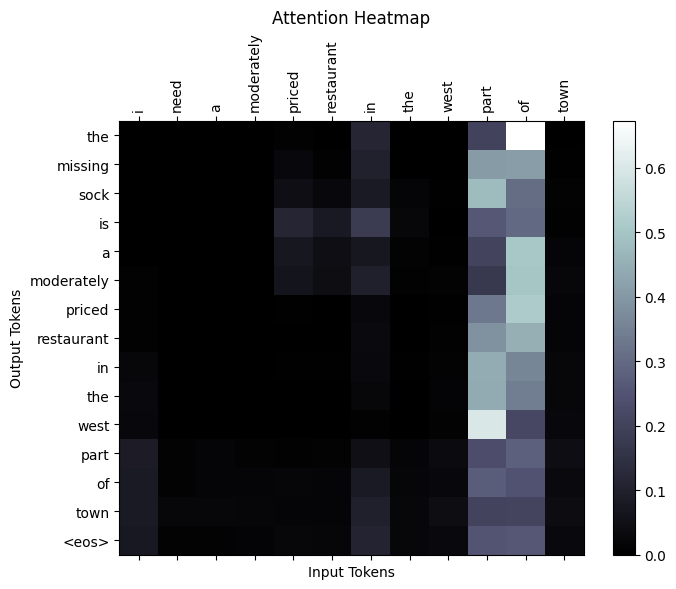

------------------------------
You: can you find me a taxi from cambridge to the airport
Bot (Attention): i can help you with that where are you departing from

Attention matrix cols (13) != input tokens (11). Adjusting for plot.


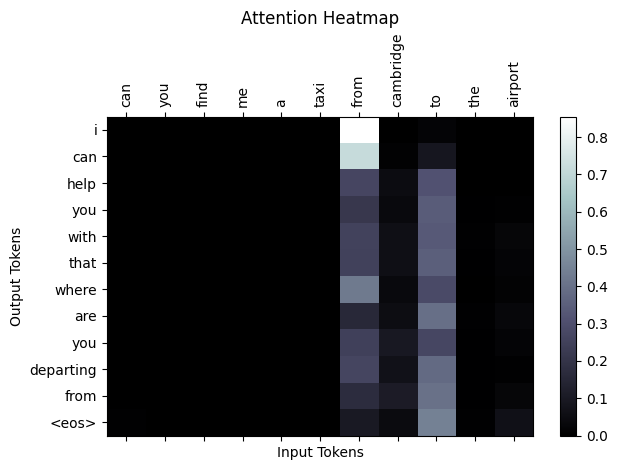

------------------------------
You: what is the postcode and address
Bot (Attention): the address is parkside cambridge postcode cb11jg

Attention matrix cols (8) != input tokens (6). Adjusting for plot.


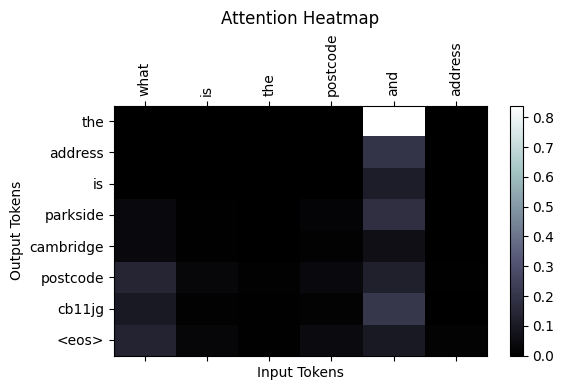

------------------------------
You: book a table for three people at 7pm on tuesday
Bot (Attention): your table is reserved for 15 minutes reference number is <unk>

Attention matrix cols (12) != input tokens (10). Adjusting for plot.


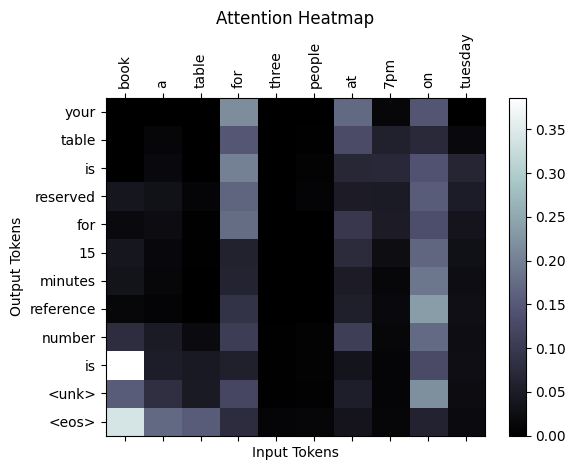

------------------------------


In [8]:
print("\n--- Training Seq2Seq Model WITH ATTENTION ---")
# --- 2.3.6 ---
attn_encoder = EncoderLSTM(VOCAB_SIZE_SEQ2SEQ, EMBEDDING_DIM_SEQ2SEQ, HIDDEN_DIM, # hid_dim_encoder = HIDDEN_DIM
                           NUM_LSTM_LAYERS, dropout=0.2, pretrained_vecs=pretrained_embeddings).to(DEVICE)
attention_module = Attention(hid_dim_encoder=HIDDEN_DIM, hid_dim_decoder=HIDDEN_DIM).to(DEVICE)
attn_decoder = DecoderWithAttention(VOCAB_SIZE_SEQ2SEQ, EMBEDDING_DIM_SEQ2SEQ,
                                    hid_dim_encoder=HIDDEN_DIM, hid_dim_decoder=HIDDEN_DIM, # Pass both
                                    n_layers=NUM_LSTM_LAYERS, dropout=0.2,
                                    attention_module=attention_module,
                                    pretrained_vecs=pretrained_embeddings).to(DEVICE)
model_attn = Seq2SeqAttn(attn_encoder, attn_decoder, DEVICE).to(DEVICE)

print(f'Attention Model parameters: {count_parameters(model_attn):,}')
optimizer_attn = optim.Adam(model_attn.parameters(), lr=LEARNING_RATE)
# Criterion is the same

# <<<<<<< NEW: List to store training losses for the attention model >>>>>>>
attn_model_train_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"Attention Model - Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss = train_epoch(model_attn, train_dataloader, optimizer_attn, criterion)
    attn_model_train_losses.append(train_loss) # <<<<<<< NEW: Store loss >>>>>>>
    print(f"Attention Model - Epoch {epoch+1} Summary: Train Loss: {train_loss:.3f}")

print("Attention Model training finished.")

# --- Testing Attention Model & Displaying Heatmaps ---
print("\n--- Testing Attention Model & Showing Heatmaps ---")
test_inputs_attn = [
    "i need a moderately priced restaurant in the west part of town",
    "can you find me a taxi from cambridge to the airport",
    "what is the postcode and address",
    "book a table for three people at 7pm on tuesday"
]
responses_attn = {} # Keep this if you want to store responses
for inp in test_inputs_attn:
    response, attention_data = generate_interactive_response(inp, model_attn, return_attention=True)
    responses_attn[inp] = response
    print(f"You: {inp}")
    print(f"Bot (Attention): {response}\n")
    if attention_data:
        input_tokens_vis, output_tokens_vis, attention_matrix_vis = attention_data
        if output_tokens_vis and input_tokens_vis and attention_matrix_vis.size > 0 :
            display_attention(input_tokens_vis, output_tokens_vis, attention_matrix_vis)
        else:
            print("Not enough data or empty tokens to display attention heatmap for this example.")
    print("-" * 30)



--- Plotting Training Loss Curves ---


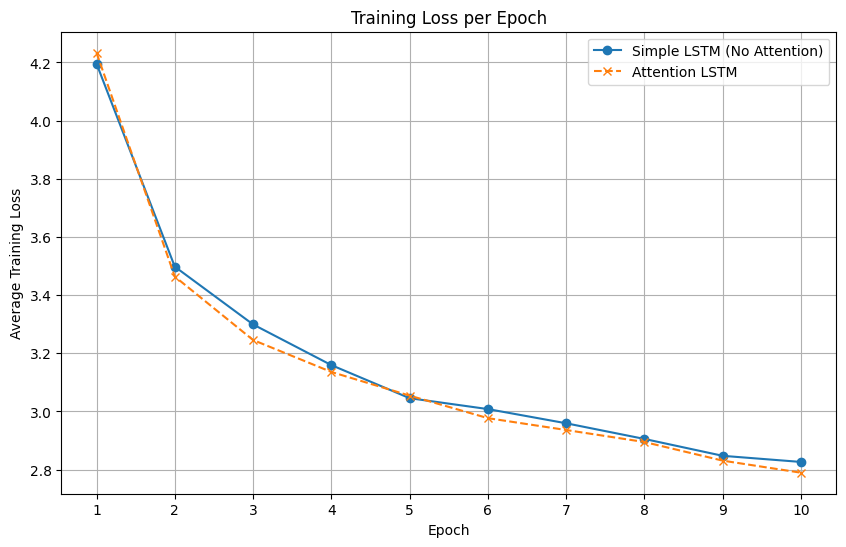



--- 2.3.7 Comparison of Chatbot Results (Textual) ---
Comparing responses from Simple LSTM vs. Attention LSTM for the same inputs.

Note: The quality of responses heavily depends on training data, hyperparameters, and training duration.
A simple LSTM without attention might struggle with longer dependencies or specific keyword focus.

INPUT: "hello"
  Bot (Simple LSTM): "the cambridge chop house"
  Bot (Attention LSTM): "do you need"
  (Attention Heatmap for above Attention LSTM response)
Attention matrix cols (3) != input tokens (1). Adjusting for plot.


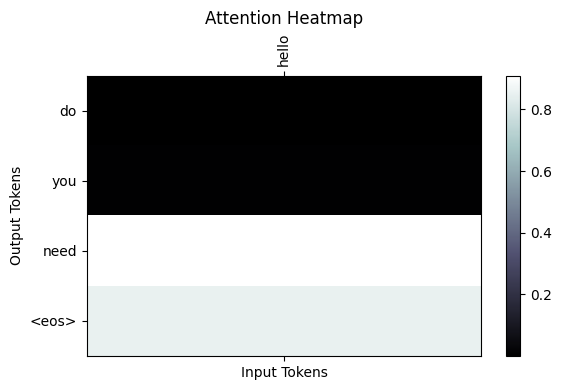

--------------------------------------------------

INPUT: "i'm looking for a place to stay"
  Bot (Simple LSTM): "i can help you with that what area would you like to stay in"
  Bot (Attention LSTM): "there are a price range you would like to stay in"
  (Attention Heatmap for above Attention LSTM response)
Attention matrix cols (10) != input tokens (8). Adjusting for plot.


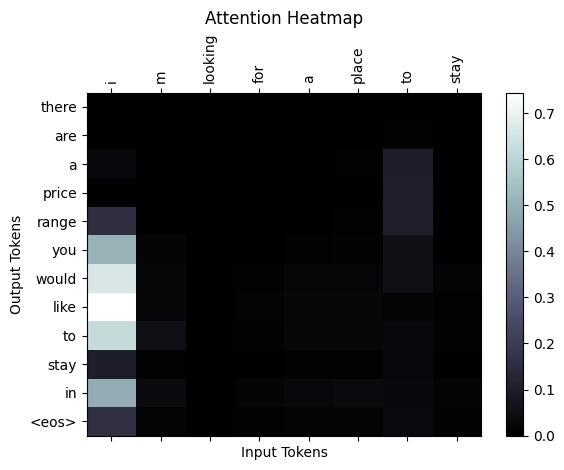

--------------------------------------------------

INPUT: "is there anything in the cheap price range"
  Bot (Simple LSTM): "i have t have any cheap hotels in the"
  Bot (Attention LSTM): "i have one that is cheap would you like to book a"
  (Attention Heatmap for above Attention LSTM response)
Attention matrix cols (10) != input tokens (8). Adjusting for plot.


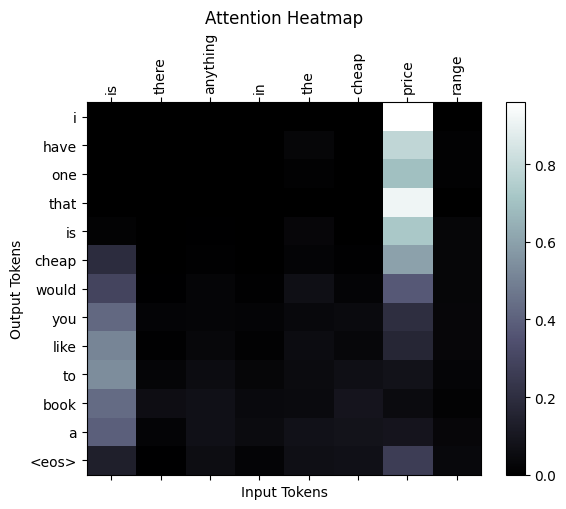

--------------------------------------------------

INPUT: "what type of food do they serve"
  Bot (Simple LSTM): "they serve british food"
  Bot (Attention LSTM): "it is a chinese restaurant"
  (Attention Heatmap for above Attention LSTM response)
Attention matrix cols (9) != input tokens (7). Adjusting for plot.


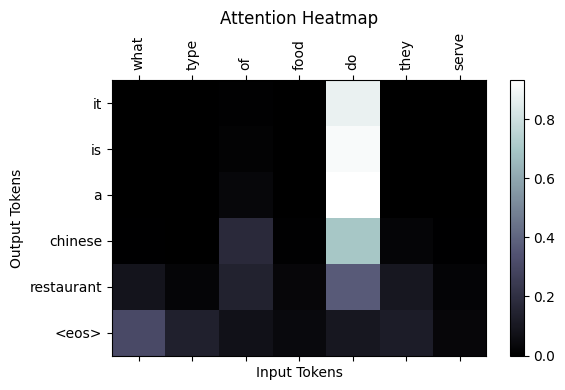

--------------------------------------------------

INPUT: "thank you that will be all"
  Bot (Simple LSTM): "glad to help have a great day"
  Bot (Attention LSTM): "thank you for using our service have a great day"
  (Attention Heatmap for above Attention LSTM response)
Attention matrix cols (8) != input tokens (6). Adjusting for plot.


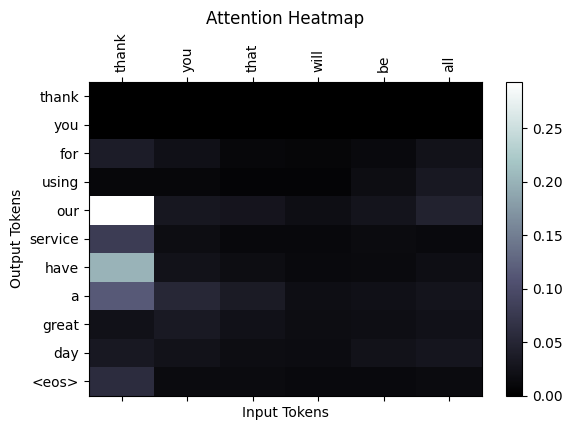

--------------------------------------------------


Qualitative Comparison Points:
1. Coherence: Is the response grammatically correct and sensible?
2. Relevance: Does the response address the input query appropriately?
3. Specificity: Does the attention model seem to focus on key parts of the input to generate more specific answers?
4. Repetitiveness: Do models get stuck in loops or repeat phrases?
5. Handling of longer inputs: Does attention help maintain context for longer user utterances?


In [9]:
# --- 2.3.7 Perform a comparison of the Chatbot results with and without attention ---
# --- AND Plot Training Loss Curves ---

print("\n\n--- Plotting Training Loss Curves ---")

plt.figure(figsize=(10, 6))
if 'simple_model_train_losses' in globals() and simple_model_train_losses:
    plt.plot(range(1, len(simple_model_train_losses) + 1), simple_model_train_losses, marker='o', linestyle='-', label='Simple LSTM (No Attention)')
else:
    print("No training loss data found for Simple LSTM Model.")

if 'attn_model_train_losses' in globals() and attn_model_train_losses:
    plt.plot(range(1, len(attn_model_train_losses) + 1), attn_model_train_losses, marker='x', linestyle='--', label='Attention LSTM')
else:
    print("No training loss data found for Attention LSTM Model.")

if ('simple_model_train_losses' in globals() and simple_model_train_losses) or \
   ('attn_model_train_losses' in globals() and attn_model_train_losses):
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Training Loss')
    plt.xticks(range(1, NUM_EPOCHS + 1)) # Ensure x-axis ticks match epochs
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No loss data available to plot.")


print("\n\n--- 2.3.7 Comparison of Chatbot Results (Textual) ---")
print("Comparing responses from Simple LSTM vs. Attention LSTM for the same inputs.")

comparison_inputs = [
    "hello",
    "i'm looking for a place to stay",
    "is there anything in the cheap price range",
    "what type of food do they serve",
    "thank you that will be all"
]

print("\nNote: The quality of responses heavily depends on training data, hyperparameters, and training duration.")
print("A simple LSTM without attention might struggle with longer dependencies or specific keyword focus.\n")

# Ensure models are available before trying to generate responses for comparison
simple_model_available = 'model_simple' in globals() and model_simple is not None
attn_model_available = 'model_attn' in globals() and model_attn is not None

for inp_sentence in comparison_inputs:
    print(f"INPUT: \"{inp_sentence}\"")

    if simple_model_available:
        response_simple, _ = generate_interactive_response(inp_sentence, model_simple)
        print(f"  Bot (Simple LSTM): \"{response_simple}\"")
    else:
        print("  Bot (Simple LSTM): Model not trained or available for comparison.")

    if attn_model_available:
        response_attn, attn_details = generate_interactive_response(inp_sentence, model_attn, return_attention=True)
        print(f"  Bot (Attention LSTM): \"{response_attn}\"")

        if attn_details:
            in_tok_vis, out_tok_vis, attn_mat_vis = attn_details
            if out_tok_vis and in_tok_vis and attn_mat_vis.size > 0 :
                print("  (Attention Heatmap for above Attention LSTM response)")
                display_attention(in_tok_vis, out_tok_vis, attn_mat_vis)
            # else: # This can be a bit verbose if it prints for every example
                # print("  (Could not generate heatmap for this attention response)")
    else:
        print("  Bot (Attention LSTM): Model not trained or available for comparison.")
    print("-" * 50 + "\n")

print("\nQualitative Comparison Points:")
print("1. Coherence: Is the response grammatically correct and sensible?")
print("2. Relevance: Does the response address the input query appropriately?")
print("3. Specificity: Does the attention model seem to focus on key parts of the input to generate more specific answers?")
print("4. Repetitiveness: Do models get stuck in loops or repeat phrases?")
print("5. Handling of longer inputs: Does attention help maintain context for longer user utterances?")

In [10]:
# --- Cell 11: Interactive Chat Session (Revised for Optional Heatmap) ---
print("\n\n--- Interactive Chat Session ---")

def run_interactive_chat_revised(model, model_name, is_attention_model=False):
    print(f"\nStarting interactive chat with: {model_name}")
    print("Type 'quit' or 'exit' to end this chat session.")
    if is_attention_model:
        print("Type your message, or type 'message --showattn' to also see the attention heatmap for that message.")
    print("Type '--switch' to go back and choose another model or exit.")

    while True:
        user_input_raw = input("You: ")
        user_input = user_input_raw.strip()

        show_current_attn = False
        if is_attention_model and user_input.lower().endswith(" --showattn"):
            user_input = user_input[:-len(" --showattn")].strip() # Remove the flag from the actual message
            show_current_attn = True

        if user_input.lower() in ['quit', 'exit']:
            print(f"{model_name} ChatBot: Goodbye!")
            break
        if user_input.lower() == '--switch':
            print("Switching model...")
            break

        if not user_input: # Check after stripping and removing flag
            print(f"{model_name} ChatBot: Please say something.")
            continue

        response, attention_data = generate_interactive_response(
            user_input,
            model,
            # Only request attention data if it's an attention model AND user requested it for this turn
            return_attention=(is_attention_model and show_current_attn)
        )
        print(f"{model_name} ChatBot: {response}")

        if is_attention_model and show_current_attn and attention_data:
            input_tokens_vis, output_tokens_vis, attention_matrix_vis = attention_data
            if output_tokens_vis and input_tokens_vis and attention_matrix_vis.size > 0:
                # print("(Displaying Attention Heatmap as requested)") # Optional confirmation
                display_attention(input_tokens_vis, output_tokens_vis, attention_matrix_vis)
            else:
                print("(Could not generate heatmap for this response despite request; possibly empty tokens or no attention data).")
        elif is_attention_model and show_current_attn and not attention_data:
             print("(Attention data was requested but not returned by the generation function.)")

    return None

# Main loop for choosing model and chatting
while True:
    print("\nWhich model would you like to chat with?")
    print("1. Simple LSTM Model (No Attention)")
    print("2. Attention LSTM Model")
    print("3. Exit Interactive Chat")

    choice = input("Enter your choice (1, 2, or 3): ")

    if choice == '1':
        if 'model_simple' in globals() and model_simple is not None:
            run_interactive_chat_revised(model_simple, "Simple LSTM", is_attention_model=False)
        else:
            print("Simple LSTM model is not available. Please train it first (Cell 8).")
    elif choice == '2':
        if 'model_attn' in globals() and model_attn is not None:
            run_interactive_chat_revised(model_attn, "Attention LSTM", is_attention_model=True)
        else:
            print("Attention LSTM model is not available. Please train it first (Cell 9).")
    elif choice == '3':
        print("Exiting interactive chat. Goodbye!")
        break
    else:
        print("Invalid choice. Please enter 1, 2, or 3.")



--- Interactive Chat Session ---

Which model would you like to chat with?
1. Simple LSTM Model (No Attention)
2. Attention LSTM Model
3. Exit Interactive Chat
Enter your choice (1, 2, or 3): 1

Starting interactive chat with: Simple LSTM
Type 'quit' or 'exit' to end this chat session.
Type '--switch' to go back and choose another model or exit.
You: hello
Simple LSTM ChatBot: the cambridge chop house
You: i'm looking for a place to stay
Simple LSTM ChatBot: i can help you with that what area would you like to stay in
You: place in center of the city
Simple LSTM ChatBot: there are a few of options what type of food would you like
You: European Food
Simple LSTM ChatBot: there are no restaurants restaurants in the
You: i need a moderately priced restaurant in the west part of town
Simple LSTM ChatBot: there are two restaurants that meet your criteria would you like to narrow it down
You: yes, please
Simple LSTM ChatBot: the address is is street
You: can you find me a taxi from cambridg